In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time

In [3]:
from dataprep.helperfunctions import *
from dataprep.memory_helperfunctions import prepare_data_f_memory

In [4]:
from simulation.simulation_pipeline import *
from simulation.simulation_helpers import *

In [5]:
import pomegranate

In [6]:
from experiment.DoE import *

# Make a design table

In [7]:
run_settings = {"process_entropy":["min_entropy","med_entropy","max_entropy"], #,"med_entropy","max_entropy","med_entropy","max_entropy"
                "number_of_traces":[100],
                "statespace_size":[5],
                "process_type":["memoryless","memory"],        #"memoryless","memory" 
                
                #order of HOMC
                "process_memory":[4],
                
                #number of transitions
                "med_ent_n_transitions":[3],
                                
                #lambda parameter of inter-arrival times
                "inter_arrival_time":[1.5],
                #lambda parameter of process noise
                "process_stability_scale":[0.1],
                
                #probability of getting an agent
                "resource_availability_p":[0.5],
                #number of agents
                "resource_availability_n":[3],
                #waiting time in days, when no agent is available
                "resource_availability_m":[0.041],
                
                #variation between activity durations
                "activity_duration_lambda_range":[1],
                #business hours definition: when can cases be processed?
                "Deterministic_offset_W":["weekdays"], #weekdays, all-week
                #time-unit for a full week: days = 7, hrs = 24*7, etc.
                "Deterministic_offset_u":[7],
                
                #run full model pipeline from simulated data
                "model_pipeline":[False],
                
                #repeat the experiment
                "num_replications":list(range(0,10))
               }


# Generate a full factorial:
df=build_full_fact(run_settings)#[0:2]

# Recode the string factor levels (recoding from natural number to string)
df = fix_label_values(df, run_settings, variables = ["process_entropy",
                                                     "process_type",
                                                     "Deterministic_offset_W",
                                                     "model_pipeline"])
df = df.drop("Name_fix",axis=1)
# Important variables
df["RUN"] = df.index + 1
df["Done"] = 0
df["Failure"] = 0

#change types and save
df.statespace_size = df.statespace_size.astype(int)
df.to_csv("results/design_table.csv",index=False)
df

,process_entropy,number_of_traces,statespace_size,process_type,process_memory,med_ent_n_transitions,inter_arrival_time,process_stability_scale,resource_availability_p,resource_availability_n,resource_availability_m,activity_duration_lambda_range,Deterministic_offset_W,Deterministic_offset_u,model_pipeline,num_replications,RUN,Done,Failure
0,min_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,1,0,0
1,med_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,2,0,0
2,max_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,3,0,0
3,min_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,4,0,0
4,med_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,5,0,0
5,max_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,6,0,0
6,min_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,1.0,7,0,0
7,med_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,1.0,8,0,0
8,max_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,1.0,9,0,0
9,min_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,1.0,10,0,0


In [8]:
#df = df.loc[:1]
#df

# Perform the experiments

In [9]:
results = []

for run in df.index:
    print(run)
    
    start_time = time.time()
    
    """
    Settings from experiments
    """
    curr_settings = df.loc[run]
    
    """
    settings for the simulation
    """
    
    SIM_SETTINGS = {"save_eventlog":1, #0 = no, 1 = yes...
                
                "statespace_size":make_D(int(curr_settings["statespace_size"])),

                "number_of_traces":int(curr_settings["number_of_traces"]),  

                "process_entropy":curr_settings["process_entropy"],

                "process_type":curr_settings["process_type"],                

                "process_memory":int(curr_settings["process_memory"]),          
                    
                # desired max number of possible transitions in P. 
                # NOTE: This can maximally be the number of states, and should be higher than 2
                "med_ent_n_transitions":int(curr_settings["med_ent_n_transitions"]),
                    
                #lambda parameter of inter-arrival times
                "time_settings":{"inter_arrival_time":float(curr_settings["inter_arrival_time"]), 
                                 
                                #lambda parameter of process noise
                                "process_stability_scale":float(curr_settings["process_stability_scale"]),
                                 
                                #probability of getting an agent
                                "resource_availability_p":float(curr_settings["resource_availability_p"]),                          
                                #waiting time in days, when no agent is available      
                                "resource_availability_n":int(curr_settings["resource_availability_n"]),
                                #waiting time in days, when no agent is available
                                "resource_availability_m":float(curr_settings["resource_availability_m"]), 
                                 
                                #variation between activity durations
                                "activity_duration_lambda_range":float(curr_settings["activity_duration_lambda_range"]),

                                #time-unit for a full week: days = 7, hrs = 24*7, etc.
                                "Deterministic_offset_W":make_workweek(curr_settings["Deterministic_offset_W"]),

                                "Deterministic_offset_u":int(curr_settings["Deterministic_offset_u"])},
                #offset for the timestamps
                "datetime_offset":365*53,
                #run is the seed
                "run":run}

    # generate the log
    log = Generate_eventlog(SIM_SETTINGS)
    #log.to_csv("results/"+str(run)+"log.csv",index=False)
    
    # log simulated log characteristics
    curr_settings["simuation_time_sec"] = time.time() - start_time
    curr_settings["num_traces"] = len(log.caseid.unique())
    curr_settings["num_events"] = len(log)
    
    variants = []
    tracelengths = []
    for traceid in log.caseid.unique():
        trace = log.loc[log.caseid == traceid]
        #tracelen
        tracelen = len(trace)
        tracelengths.append(tracelen)
        #variant
        sequence = ""
        sequence = sequence.join(trace.activity.tolist())
        variants.append(sequence)
        
    n_variants = len(set(variants))       
    
    curr_settings["num_variants"] = n_variants
    
    curr_settings["avg_tracelen"] = np.mean(tracelengths)
    curr_settings["min_tracelen"] = np.min(tracelengths)
    curr_settings["max_tracelen"] = np.max(tracelengths)
    
    

    # run a machine learning pipeline as well?
    if curr_settings["model_pipeline"] == True:
        """
        Prepare data for modelling
        """
        input_data = prepare_data_f_memory(log)

        """
        Train a model
        """
        # X: 
        input_data["x_train"]
        input_data["x_test"]

        # Y:
        input_data["y_test"]
        input_data["y_test"]

        """
        Evaluate the model
        """

    
        """
        Store the results
        """
        curr_settings["RES_num_events"] = len(log)
        
    #append
    #curr_settings = pd.DataFrame(curr_settings.T)
    #curr_settings.index = [run]
    results.append(curr_settings)
#store results
results = pd.DataFrame(results)
results.to_csv("results/experiments.csv",index=False)  

0
traces: 100
events: 500
ids: 100
1
traces: 100
events: 417
ids: 100
2
traces: 100
events: 563
ids: 100
3
traces: 100
events: 500
ids: 100
4
generated traces: 100
traces: 100
events: 585
ids: 100
5
generated traces: 100
traces: 100
events: 667
ids: 100
6
traces: 100
events: 500
ids: 100
7
traces: 100
events: 373
ids: 100
8
traces: 100
events: 626
ids: 100
9
traces: 100
events: 500
ids: 100
10
generated traces: 100
traces: 100
events: 786
ids: 100
11
generated traces: 100
traces: 100
events: 573
ids: 100
12
traces: 100
events: 500
ids: 100
13
traces: 100
events: 756
ids: 100
14
traces: 100
events: 552
ids: 100
15
traces: 100
events: 500
ids: 100
16
generated traces: 100
traces: 100
events: 629
ids: 100
17
generated traces: 100
traces: 100
events: 499
ids: 100
18
traces: 100
events: 500
ids: 100
19
traces: 100
events: 430
ids: 100
20
traces: 100
events: 513
ids: 100
21
traces: 100
events: 500
ids: 100
22
generated traces: 100
traces: 100
events: 523
ids: 100
23
generated traces: 100
tra

In [10]:
results

,process_entropy,number_of_traces,statespace_size,process_type,process_memory,med_ent_n_transitions,inter_arrival_time,process_stability_scale,resource_availability_p,resource_availability_n,...,RUN,Done,Failure,simuation_time_sec,num_traces,num_events,num_variants,avg_tracelen,min_tracelen,max_tracelen
0,min_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,1,0,0,0.106784,100,500,1,5.00,5,5
1,med_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,2,0,0,0.093374,100,417,57,4.17,1,15
2,max_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,3,0,0,0.108770,100,563,83,5.63,1,20
3,min_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,4,0,0,0.107282,100,500,1,5.00,5,5
4,med_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,5,0,0,4.649294,100,585,90,5.85,1,14
5,max_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,6,0,0,5.495616,100,667,82,6.67,1,32
6,min_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,7,0,0,0.209063,100,500,1,5.00,5,5
7,med_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,8,0,0,0.173833,100,373,49,3.73,1,15
8,max_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,9,0,0,0.242373,100,626,82,6.26,1,25
9,min_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,10,0,0,0.204629,100,500,1,5.00,5,5


In [11]:
#log.to_csv("log.csv",index=False)
log.head()

,caseid,activity,activity_no,y_acc_sum,n_t,u_t,z_t,h_t,b_t,q_t,s_t,v_t,arrival_datetime,start_datetime,end_datetime,start_day,start_hour
0,0,e,1,0.766082,0.510266,0.766082,0.510266,0.082,0.025930,0.618196,0.000000,0.255817,2022-12-23 12:14:46,2022-12-23 14:50:12,2022-12-23 18:23:09,Friday,14
1,0,e,2,2.529883,0.766082,1.763800,0.510266,0.082,0.009302,0.857385,0.000000,0.997718,2022-12-23 18:23:09,2022-12-23 20:34:38,2022-12-24 18:19:52,Friday,20
2,0,e,3,4.590394,1.763800,2.060511,0.510266,0.123,0.023971,1.910772,0.000000,0.296711,2022-12-24 18:19:52,2022-12-24 21:51:30,2022-12-25 01:27:08,Saturday,21
3,0,c,4,8.288863,2.060511,3.698469,0.510266,0.041,0.154581,2.256092,0.243908,1.394050,2022-12-25 01:27:08,2022-12-25 12:00:00,2022-12-26 16:45:47,Sunday,12
4,0,e,5,12.399730,3.698469,4.110867,0.510266,0.041,0.002450,3.741919,0.000000,0.412397,2022-12-26 16:45:47,2022-12-26 17:48:21,2022-12-27 02:39:38,Monday,17


# Inspect example data

In [12]:
log

,caseid,activity,activity_no,y_acc_sum,n_t,u_t,z_t,h_t,b_t,q_t,s_t,v_t,arrival_datetime,start_datetime,end_datetime,start_day,start_hour
0,0,e,1,0.766082,0.510266,0.766082,0.510266,0.082,0.025930,0.618196,0.000000,0.255817,2022-12-23 12:14:46,2022-12-23 14:50:12,2022-12-23 18:23:09,Friday,14
1,0,e,2,2.529883,0.766082,1.763800,0.510266,0.082,0.009302,0.857385,0.000000,0.997718,2022-12-23 18:23:09,2022-12-23 20:34:38,2022-12-24 18:19:52,Friday,20
2,0,e,3,4.590394,1.763800,2.060511,0.510266,0.123,0.023971,1.910772,0.000000,0.296711,2022-12-24 18:19:52,2022-12-24 21:51:30,2022-12-25 01:27:08,Saturday,21
3,0,c,4,8.288863,2.060511,3.698469,0.510266,0.041,0.154581,2.256092,0.243908,1.394050,2022-12-25 01:27:08,2022-12-25 12:00:00,2022-12-26 16:45:47,Sunday,12
4,0,e,5,12.399730,3.698469,4.110867,0.510266,0.041,0.002450,3.741919,0.000000,0.412397,2022-12-26 16:45:47,2022-12-26 17:48:21,2022-12-27 02:39:38,Monday,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,99,b,1,162.855271,161.973127,162.855271,161.973127,0.082,0.009203,1.064329,0.435671,0.446473,2023-06-02 23:21:18,2022-12-24 12:00:00,2023-06-03 20:31:35,Saturday,12
585,99,f,2,326.633048,162.855271,163.777778,161.973127,0.082,0.027312,1.964583,0.000000,0.922507,2023-06-03 20:31:35,2022-12-24 23:08:59,2023-06-04 18:39:59,Saturday,23
586,99,e,3,490.676964,163.777778,164.043915,161.973127,0.082,0.041573,2.901351,0.000000,0.266138,2023-06-04 18:39:59,2022-12-25 21:37:56,2023-06-05 01:03:14,Sunday,21
587,99,f,4,655.370986,164.043915,164.694022,161.973127,0.082,0.084444,3.210360,0.289640,0.360466,2023-06-05 01:03:14,2022-12-26 12:00:00,2023-06-05 16:39:23,Monday,12


In [13]:
log['arrival_datetime'].describe()

count                     589
unique                    589
top       2022-12-23 12:14:46
freq                        1
first     2022-12-23 12:14:46
last      2023-06-05 16:39:23
Name: arrival_datetime, dtype: object

<AxesSubplot:xlabel='arrival_datetime'>

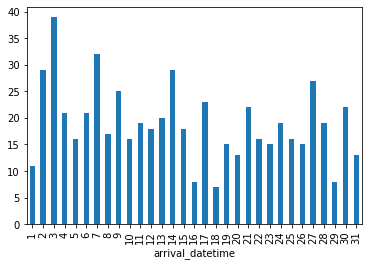

In [14]:
log['caseid'].groupby(log['arrival_datetime'].dt.day).count().plot(kind="bar")

<AxesSubplot:xlabel='arrival_datetime'>

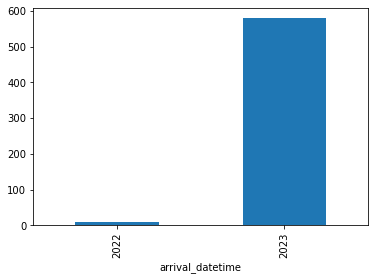

In [15]:
log['caseid'].groupby(log['arrival_datetime'].dt.year).count().plot(kind="bar") #dayofyear

In [16]:
#input_data

In [17]:
import pm4py

In [18]:
log.columns

Index(['caseid', 'activity', 'activity_no', 'y_acc_sum', 'n_t', 'u_t', 'z_t',
       'h_t', 'b_t', 'q_t', 's_t', 'v_t', 'arrival_datetime', 'start_datetime',
       'end_datetime', 'start_day', 'start_hour'],
      dtype='object')

In [19]:
log = log.rename(columns={"caseid":"case:concept:name",
                         "activity":"concept:name",
                         "start_datetime":"time:timestamp"})

dataframe = pm4py.format_dataframe(log[["case:concept:name","concept:name","time:timestamp"]], 
                                   case_id='case:concept:name', 
                                   activity_key='concept:name', 
                                   timestamp_key='time:timestamp',
                                   timest_format="yyyy-%mm-%dd %hh:%mm:%ss")

event_log = pm4py.convert_to_event_log(dataframe)
event_log

[{'attributes': {'concept:name': '0'}, 'events': [{'concept:name': 'e', 'time:timestamp': Timestamp('2022-12-23 14:50:12'), '@@index': 0}, '..', {'concept:name': 'e', 'time:timestamp': Timestamp('2022-12-26 17:48:21'), '@@index': 4}]}, '....', {'attributes': {'concept:name': '99'}, 'events': [{'concept:name': 'b', 'time:timestamp': Timestamp('2022-12-24 12:00:00'), '@@index': 584}, '..', {'concept:name': 'b', 'time:timestamp': Timestamp('2022-12-26 22:53:50'), '@@index': 588}]}]

In [20]:
# Petri net from inductive miner
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)

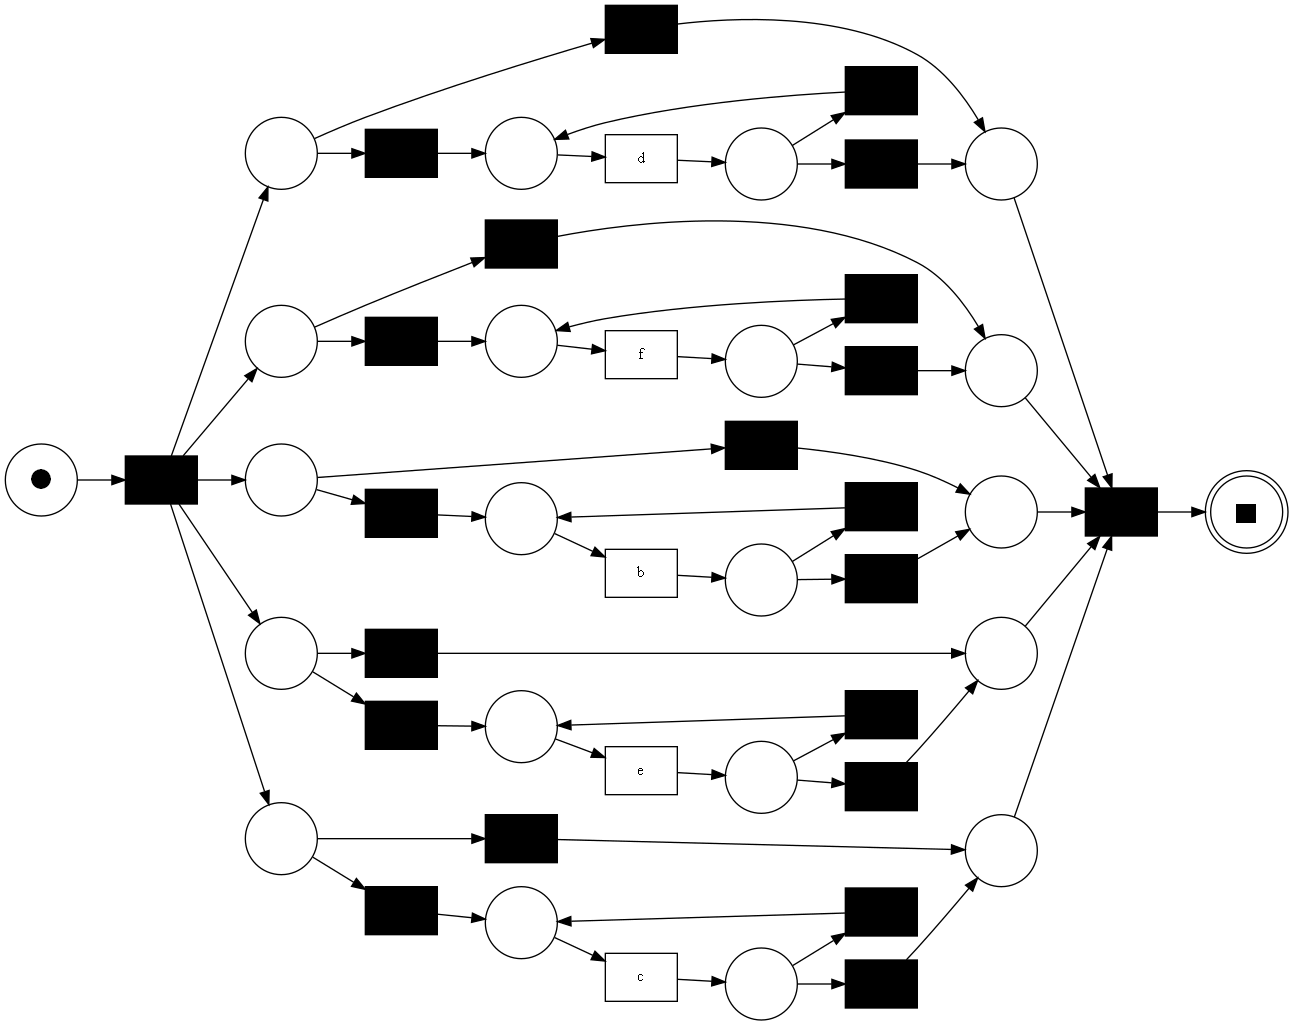

In [21]:
pm4py.view_petri_net(net, initial_marking, final_marking)

In [22]:
tree = pm4py.discover_process_tree_inductive(event_log)

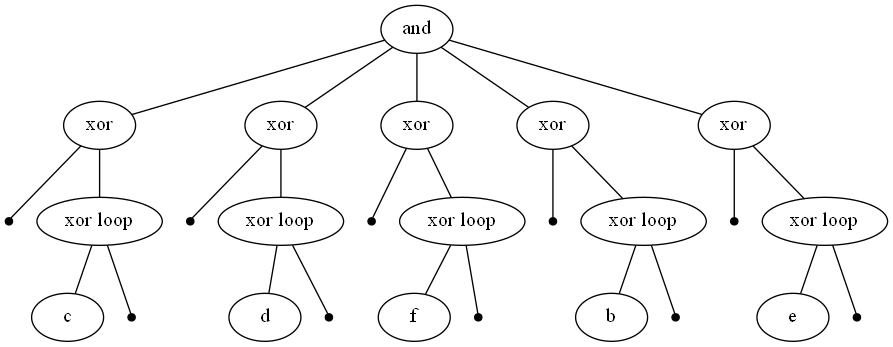

In [23]:
pm4py.view_process_tree(tree)

In [24]:
bpmn_graph = pm4py.convert_to_bpmn(tree)

In [25]:
#bpmn_graph = layouter.apply(bpmn_graph)

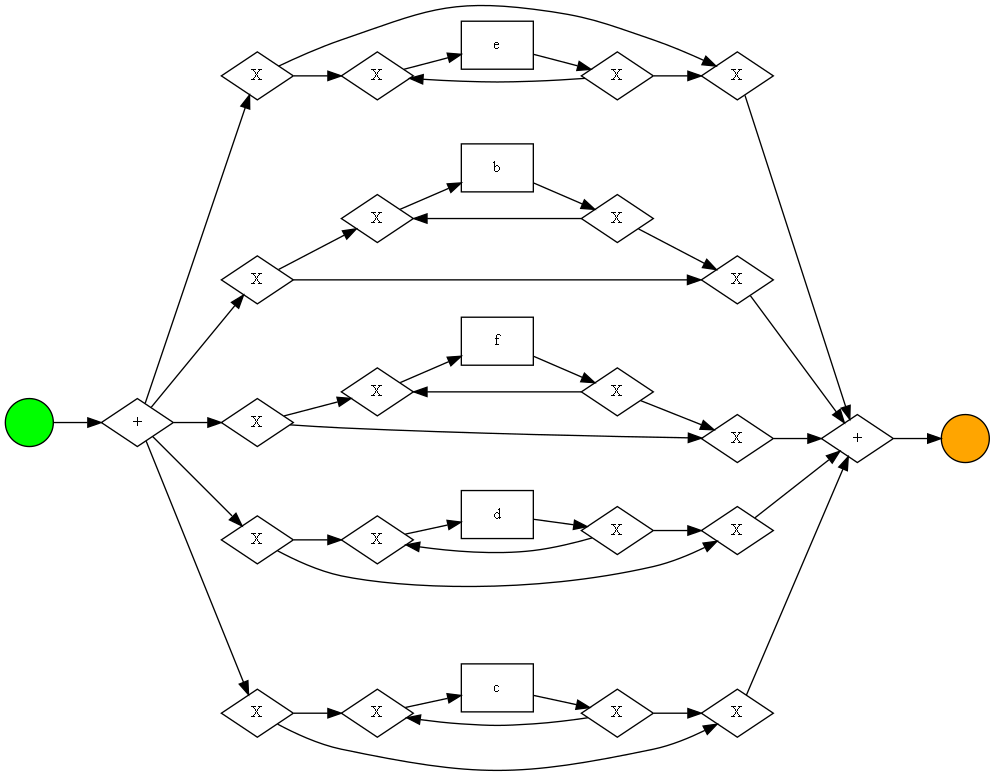

In [26]:
pm4py.view_bpmn(bpmn_graph)